# Wine Quality prediction using linear regression (minimal)

Using the boston housing dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-1.18.4               |   py37h8960a57_0         5.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.2 MB

The following packages will be UPDATED:

  numpy                               1.18.1-py37h8960a57_1 --> 1.18.4-py37h8960a57_0



numpy-1.18.4         | 5.2 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --

In [3]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [8]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


# Other constants
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
DATA_FILENAME = "winequality-red.csv"
TARGET_COLUMN = 'quality'
input_size=11
output_size=1

## Dataset & Data loaders

In [15]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME, delimiter = ';') # here you have to use delimiter ';' which will make your raw data into tabular form with colums and rows
dataframe.head()

Using downloaded and verified file: ./winequality-red.csv


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [16]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('quality', axis=1).values # axis = 1 means column
targets = dataframe[['quality']].values
inputs.shape, targets.shape

((1599, 11), (1599, 1))

In [20]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [1000, 599]) # we have total 1599

train_loader = DataLoader(train_ds, batch_size, shuffle=True) # we have to shuffle train_ds to get better accuracy
val_loader = DataLoader(val_ds, batch_size*2) # here we use batch_size*2

## Model

In [24]:
class WineModel(nn.Module):
    def __init__(self):
        super().__init__() # base class object initialization
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb): # initial loading for input data
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result): # to show epoch
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = WineModel()

## Training

In [25]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
result = evaluate(model, val_loader) # result before training
result

{'val_loss': 47.1357421875}

In [39]:
history = fit(1000, learning_rate, model, train_loader, val_loader) # training with 1000 epochs

Epoch [0], val_loss: 2.4458
Epoch [1], val_loss: 2.4439
Epoch [2], val_loss: 2.4414
Epoch [3], val_loss: 2.4388
Epoch [4], val_loss: 2.4363
Epoch [5], val_loss: 2.4338
Epoch [6], val_loss: 2.4313
Epoch [7], val_loss: 2.4288
Epoch [8], val_loss: 2.4262
Epoch [9], val_loss: 2.4235
Epoch [10], val_loss: 2.4213
Epoch [11], val_loss: 2.4190
Epoch [12], val_loss: 2.4166
Epoch [13], val_loss: 2.4141
Epoch [14], val_loss: 2.4118
Epoch [15], val_loss: 2.4095
Epoch [16], val_loss: 2.4073
Epoch [17], val_loss: 2.4050
Epoch [18], val_loss: 2.4026
Epoch [19], val_loss: 2.4000
Epoch [20], val_loss: 2.3979
Epoch [21], val_loss: 2.3957
Epoch [22], val_loss: 2.3935
Epoch [23], val_loss: 2.3910
Epoch [24], val_loss: 2.3887
Epoch [25], val_loss: 2.3867
Epoch [26], val_loss: 2.3843
Epoch [27], val_loss: 2.3818
Epoch [28], val_loss: 2.3798
Epoch [29], val_loss: 2.3772
Epoch [30], val_loss: 2.3750
Epoch [31], val_loss: 2.3728
Epoch [32], val_loss: 2.3708
Epoch [33], val_loss: 2.3685
Epoch [34], val_loss: 2.

Epoch [284], val_loss: 1.8871
Epoch [285], val_loss: 1.8854
Epoch [286], val_loss: 1.8836
Epoch [287], val_loss: 1.8819
Epoch [288], val_loss: 1.8803
Epoch [289], val_loss: 1.8786
Epoch [290], val_loss: 1.8770
Epoch [291], val_loss: 1.8753
Epoch [292], val_loss: 1.8737
Epoch [293], val_loss: 1.8722
Epoch [294], val_loss: 1.8706
Epoch [295], val_loss: 1.8690
Epoch [296], val_loss: 1.8676
Epoch [297], val_loss: 1.8659
Epoch [298], val_loss: 1.8644
Epoch [299], val_loss: 1.8630
Epoch [300], val_loss: 1.8615
Epoch [301], val_loss: 1.8599
Epoch [302], val_loss: 1.8584
Epoch [303], val_loss: 1.8567
Epoch [304], val_loss: 1.8550
Epoch [305], val_loss: 1.8534
Epoch [306], val_loss: 1.8518
Epoch [307], val_loss: 1.8503
Epoch [308], val_loss: 1.8488
Epoch [309], val_loss: 1.8473
Epoch [310], val_loss: 1.8457
Epoch [311], val_loss: 1.8442
Epoch [312], val_loss: 1.8425
Epoch [313], val_loss: 1.8410
Epoch [314], val_loss: 1.8394
Epoch [315], val_loss: 1.8376
Epoch [316], val_loss: 1.8360
Epoch [317

Epoch [565], val_loss: 1.5178
Epoch [566], val_loss: 1.5166
Epoch [567], val_loss: 1.5155
Epoch [568], val_loss: 1.5143
Epoch [569], val_loss: 1.5131
Epoch [570], val_loss: 1.5120
Epoch [571], val_loss: 1.5108
Epoch [572], val_loss: 1.5097
Epoch [573], val_loss: 1.5085
Epoch [574], val_loss: 1.5075
Epoch [575], val_loss: 1.5066
Epoch [576], val_loss: 1.5056
Epoch [577], val_loss: 1.5047
Epoch [578], val_loss: 1.5036
Epoch [579], val_loss: 1.5027
Epoch [580], val_loss: 1.5016
Epoch [581], val_loss: 1.5007
Epoch [582], val_loss: 1.4997
Epoch [583], val_loss: 1.4985
Epoch [584], val_loss: 1.4974
Epoch [585], val_loss: 1.4964
Epoch [586], val_loss: 1.4953
Epoch [587], val_loss: 1.4942
Epoch [588], val_loss: 1.4930
Epoch [589], val_loss: 1.4920
Epoch [590], val_loss: 1.4909
Epoch [591], val_loss: 1.4897
Epoch [592], val_loss: 1.4887
Epoch [593], val_loss: 1.4877
Epoch [594], val_loss: 1.4866
Epoch [595], val_loss: 1.4855
Epoch [596], val_loss: 1.4844
Epoch [597], val_loss: 1.4834
Epoch [598

Epoch [840], val_loss: 1.2741
Epoch [841], val_loss: 1.2732
Epoch [842], val_loss: 1.2723
Epoch [843], val_loss: 1.2715
Epoch [844], val_loss: 1.2707
Epoch [845], val_loss: 1.2700
Epoch [846], val_loss: 1.2694
Epoch [847], val_loss: 1.2688
Epoch [848], val_loss: 1.2680
Epoch [849], val_loss: 1.2673
Epoch [850], val_loss: 1.2667
Epoch [851], val_loss: 1.2660
Epoch [852], val_loss: 1.2652
Epoch [853], val_loss: 1.2645
Epoch [854], val_loss: 1.2638
Epoch [855], val_loss: 1.2633
Epoch [856], val_loss: 1.2626
Epoch [857], val_loss: 1.2617
Epoch [858], val_loss: 1.2610
Epoch [859], val_loss: 1.2605
Epoch [860], val_loss: 1.2597
Epoch [861], val_loss: 1.2590
Epoch [862], val_loss: 1.2583
Epoch [863], val_loss: 1.2576
Epoch [864], val_loss: 1.2568
Epoch [865], val_loss: 1.2562
Epoch [866], val_loss: 1.2557
Epoch [867], val_loss: 1.2550
Epoch [868], val_loss: 1.2542
Epoch [869], val_loss: 1.2534
Epoch [870], val_loss: 1.2528
Epoch [871], val_loss: 1.2521
Epoch [872], val_loss: 1.2515
Epoch [873

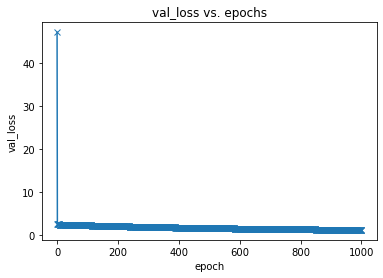

In [40]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [41]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [42]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 6.5000,  0.5300,  0.0600,  2.0000,  0.0630, 29.0000, 44.0000,  0.9949,
         3.3800,  0.8300, 10.3000])
Target:  6.0
Prediction: 5.8247222900390625


## Save and upload

In [43]:
torch.save(model.state_dict(), 'wine-linear.pth')

In [ ]:
jovian.commit(project='wine-linear-minimal', environment=None, outputs=['wine-linear.pth'])
jovian.commit(project='wine-linear-minimal', environment=None, outputs=['wine-linear.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
